<a href="https://colab.research.google.com/github/JotaDC/Entrega-Final-TPI-Data-Analytics-TalentoTech/blob/main/Ca%C3%B1ete_Javier_Dario_Comisi%C3%B3n_25261_TPI_Data_Analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Entrega Final del proyecto integrador**

  *   Curso: Data Analitics con Python
  *   Comision: 25261
  *   Alumno: Javier Dario Cañete
  *   Fecha: 30-11-2025

  **Objetivo**: Demostrar habilidades en Python, familiaridad con el entorno de trabajo y conocimientos básicos sobre manipulación de datos asi como demostrar conocimiento de las técnicas de limpieza y transformación de datos. en esta segunda parte del trabajo nos enfocamos en realizar análisis estadísticos y exploratorios sobre los datos procesados y aprender a visualizar datos de manera efectiva utilizando diversas bibliotecas.


##Etapa 1 y 2 : Fueron relizadas en la pre-entrega.
Aqui se pondran todos los pasos realizados en la pre entrega hasta obtener los datos listos para empezar a con el trabajo final.


In [8]:
# ----------------------------------------------------
# Importamos módulos (Librerías basicas)
# ----------------------------------------------------
import pandas as pd
import numpy as np

# ----------------------------------------------------
# Cargamos los DataFrames
# ----------------------------------------------------
ventas    = pd.read_csv("ventas.csv")
clientes  = pd.read_csv("clientes.csv")
marketing = pd.read_csv("marketing.csv")


# ----------------------------------------------------
# Ahora, repito los pasos de limpieza y normalización
# de datos que hicimos en la primer parte.
# ----------------------------------------------------
# 1) Normalizar 'precio' (string a float)
if 'precio' in ventas.columns:
    ventas['precio'] = (ventas['precio']
                        .astype(str)
                        .str.replace(r'[$,\s]', '', regex=True)
                        .replace({'nan': np.nan}))   # respeta nulos reales
    ventas['precio'] = pd.to_numeric(ventas['precio'], errors='coerce')

# 2) Parsear fechas en "ventas" y "marketing"
if 'fecha_venta' in ventas.columns:
    ventas['fecha_venta'] = pd.to_datetime(ventas['fecha_venta'], dayfirst=True, errors='coerce')

for col in ['fecha_inicio', 'fecha_fin']:
    if col in marketing.columns:
        marketing[col] = pd.to_datetime(marketing[col], dayfirst=True, errors='coerce')

# 3) Eliminar filas con nulos críticos en "ventas"
mask_validos = ventas['precio'].notna() & ventas['cantidad'].notna()
eliminados_nulos = (~mask_validos).sum()
ventas = ventas[mask_validos].copy()


# 4) Eliminar duplicados exactos en ventas
len_antes = len(ventas)
ventas = ventas.drop_duplicates().copy()
len_despues = len(ventas)
dup_eliminados = len_antes - len_despues

# 5) Crear columna "importe" en ventas
ventas['importe'] = ventas['precio'] * ventas['cantidad']

# ----------------------------------------------------
# Agregación global por producto (VENTAS)
# ----------------------------------------------------
ventas_prod = (ventas
               .groupby('producto', as_index=False)
               .agg(ventas_total=('importe', 'sum'),
                    unidades_vendidas=('cantidad', 'sum')))

ventas_prod = ventas_prod.sort_values('ventas_total', ascending=False, ignore_index=True)

# ----------------------------------------------------
# Agregación global por producto (MARKETING)
# ----------------------------------------------------
mkt_prod = (marketing
            .groupby('producto', as_index=False)
            .agg(inversion_total=('costo', 'sum'),
                 campañas=('id_campanha', 'count')))

mkt_prod = mkt_prod.sort_values('inversion_total', ascending=False, ignore_index=True)

# ----------------------------------------------------
# merge por producto (outer)
# ----------------------------------------------------
prod_global = (ventas_prod
               .merge(mkt_prod, on='producto', how='outer'))

# Acomodamos posibles NaN cuando un producto existe solo en una de las fuentes
# guardando un cero en esas posiciones.
for col in ['ventas_total', 'unidades_vendidas', 'inversion_total', 'campañas']:
    if col in prod_global.columns:
        prod_global[col] = prod_global[col].fillna(0)



# ----------------------------------------------------
# Creaciṕn de Indicadores Derivados
#
# Ticket medio: ventas_total / unidades_vendidas (evitando dividir por 0)
# ROAS: ventas_total / inversion_total (si no hay inversión ponemos "0")
# Ordenamos la tabla por `ventas_total` (descendente)
# ----------------------------------------------------

# Ticket medio: ventas_total / unidades_vendidas
prod_global['ticket_medio'] = prod_global.apply(
    lambda r: (r['ventas_total'] / r['unidades_vendidas']) if r['unidades_vendidas'] else 0,
    axis=1
).round(2)

# ROAS: ventas_total / inversion_total
prod_global['ROAS'] = prod_global.apply(
    lambda r: (r['ventas_total'] / r['inversion_total']) if r['inversion_total'] else 0,
    axis=1
).round(2)

# Orden: por ventas_total, descendente
prod_global = prod_global.sort_values(['ventas_total', 'inversion_total'], ascending=[False, False], ignore_index=True)
prod_global.sample(10)

,producto,ventas_total,unidades_vendidas,inversion_total,campañas,ticket_medio,ROAS
0,Lámpara de mesa,82276.38,1112.0,15.93,3,73.99,5164.87
11,Aspiradora,50085.86,651.0,16.46,3,76.94,3042.88
10,Freidora eléctrica,50155.15,630.0,13.56,3,79.61,3698.76
25,Cortinas,44865.03,610.0,17.36,3,73.55,2584.39
27,Tablet,25856.57,374.0,12.72,3,69.14,2032.75
3,Cafetera,59607.31,765.0,18.16,3,77.92,3282.34
22,Elementos de cerámica,45411.09,636.0,16.87,3,71.40,2691.83
16,SmartWatch,47836.86,620.0,14.50,3,77.16,3299.09
26,Alfombra,44773.06,615.0,17.46,3,72.80,2564.32
28,Heladera,25736.80,330.0,13.11,3,77.99,1963.14


In [9]:
ventas.head()

,id_venta,producto,precio,cantidad,fecha_venta,categoria,importe
0,792,Cuadro decorativo,69.94,5.0,2024-01-02,Decoración,349.70
1,811,Lámpara de mesa,105.10,5.0,2024-01-02,Decoración,525.50
2,1156,Secadora,97.96,3.0,2024-01-02,Electrodomésticos,293.88
3,1372,Heladera,114.35,8.0,2024-01-02,Electrodomésticos,914.80
4,1546,Secadora,106.21,4.0,2024-01-02,Electrodomésticos,424.84


# Entrega Final
## Etapa 3 - Analisis de Datos

Objetivo: Realizar análisis estadísticos y exploratorios sobre los datos procesados.
Actividades:
1. Estadística Descriptiva: Calcular medidas de tendencia central y dispersión
sobre las ventas. Presentar los resultados en un informe.
2. Análisis Exploratorio de Datos (EDA): Realizar un análisis
exploratorio utilizando visualizaciones para identificar patrones y tendencias
en las ventas.
3. Correlación: Evaluar la relación entre diferentes variables (por ejemplo,
precio y cantidad vendida) y mostrar los resultados en un gráfico.
4. Consolidación de Datos: Consolidar todos los análisis previos y preparar un
conjunto de datos final que resuma los hallazgos clave para la presentación.

### 3.1 Estadistica Descriptiva
Calcular medidas de tendencia central y dispersión
sobre las ventas. Presentar los resultados en un informe.

In [10]:

# Importamos las librerias necesarias para el analisis y las graficas

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
sns.set_theme(style="whitegrid")
%matplotlib inline


In [11]:

#Estadistica descriptiva del Importe de Venta

print("Estadistica descriptiva del IMPORTE de cada venta:")
ventas['importe'].describe()

Estadistica descriptiva del IMPORTE de cada venta:


,importe
count,2998.000000
mean,489.357412
std,334.281817
min,26.300000
25%,220.920000
50%,418.065000
75%,709.920000
max,1488.120000


In [12]:
#Estadistica descriptiva de variables agregadas

print("Estadistica descriptiva por PRODUCTO (ventas_total, unidades_vendidas, ticket_medio, ROAS):")
prod_global[['ventas_total', 'unidades_vendidas', 'ticket_medio', 'ROAS']].describe()

Estadistica descriptiva por PRODUCTO (ventas_total, unidades_vendidas, ticket_medio, ROAS):


,ventas_total,unidades_vendidas,ticket_medio,ROAS
count,30.000000,30.000000,30.000000,30.000000
mean,48903.117333,649.833333,74.989667,3322.291333
std,13265.561715,169.020522,3.042294,889.230993
min,11128.800000,160.000000,69.140000,759.650000
25%,45601.920000,623.750000,72.967500,3040.810000
50%,48140.245000,635.500000,74.820000,3379.680000
75%,51092.960000,672.000000,77.115000,3610.265000
max,82276.380000,1112.000000,81.400000,5164.870000


**Informe sobre los resultados**

Ventas:
*   El total de ventas registradas es de 2.998
*   El importe promedio de las ventas es 489.36
*   Desviación estándar std = 334.28. Esto significa que los importes varían bastante entre sí
*   La venta más baja registrada fue de 26.30, una diferencia muy grande respecto del promedio y el máximo
*   La venta más alta registrada es 1488.12. Es aproximadamente 3 veces el promedio, inidcando posible asimetría.
*   La mediana (418.07) es menor que la media (489.36). Esto sugiere una asimetría positiva (distribución a la derecha), hay ventas altas que “empujan” el promedio hacia arriba
*   Entre el 25% y el 75% los valores van de 220 a 709.92, lo cual indica una alta dispersión dentro de las ventas típicas.

Variables agregadas por producto:

ventas totales:

*   Existe alta dispersión entre productos.
*   La mayoría de los productos están entre 45.601 (Q1) y 51.092 (Q3), pero existen productos con ventas muy superiores y otros con ventas muy bajas.

Unidades vendidas:

*   Gran diferencia entre productos: algunos venden solo 160 unidades, mientras otros superan 1.100.
*   La dispersión es significativa (169 unidades).
*   Entre Q1 (623,75) y Q3 (672), los productos se agrupan; sin embargo, hay valores muy alejados, hacia arriba y abajo.

Ticket Medio:

*   Es la variable más estable del conjunto.
*   La diferencia entre el menor ticket (69,14) y el mayor (81,40) es apenas de 12,26.

ROAS:

*   Alta variabilidad, algunos productos generan un ROAS excelente (5164,87), mientras otros tienen un retorno muy bajo (759,65).












### 3.2 Analisis exploratorio (EDA)
Realizar un análisis
exploratorio utilizando visualizaciones para identificar patrones y tendencias
en las ventas.

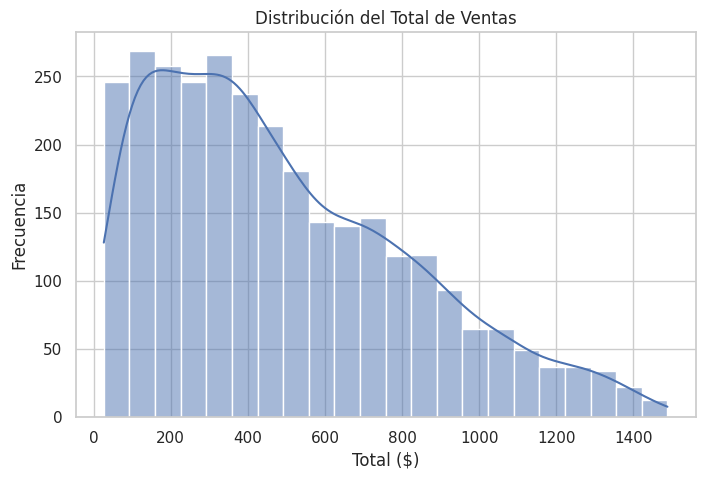

In [13]:

#Distribucion de ventas
plt.figure(figsize=(8,5))
sns.histplot(ventas["importe"], kde=True)
plt.title("Distribución del Total de Ventas")
plt.xlabel("Total ($)")
plt.ylabel("Frecuencia")
plt.show()

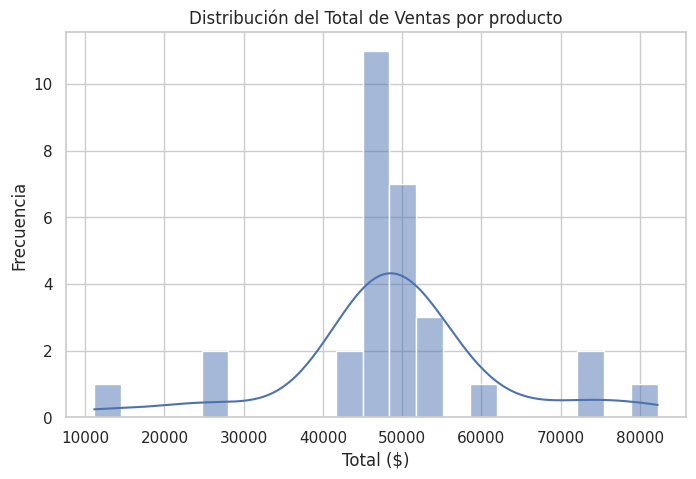

In [14]:
#Distribucion de ventas total por producto
plt.figure(figsize=(8,5))
sns.histplot(prod_global["ventas_total"], kde=True)
plt.title("Distribución del Total de Ventas por producto")
plt.xlabel("Total ($)")
plt.ylabel("Frecuencia")
plt.show()



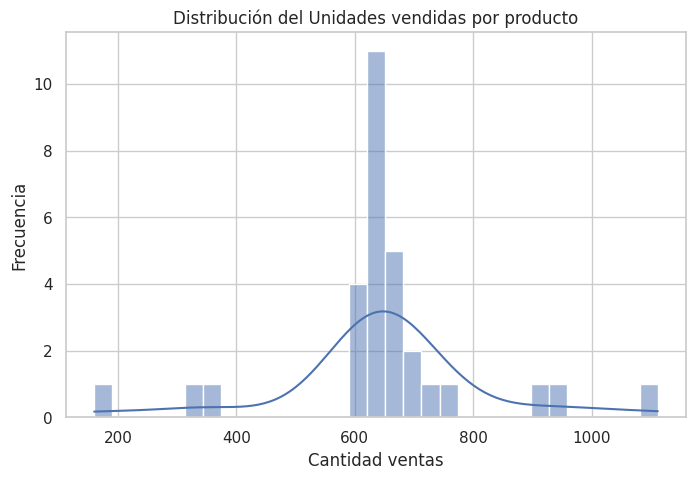

In [15]:
#Distribucion de unidades vendidas
plt.figure(figsize=(8,5))
sns.histplot(prod_global["unidades_vendidas"], kde=True)
plt.title("Distribución del Unidades vendidas por producto")
plt.xlabel("Cantidad ventas")
plt.ylabel("Frecuencia")
plt.show()


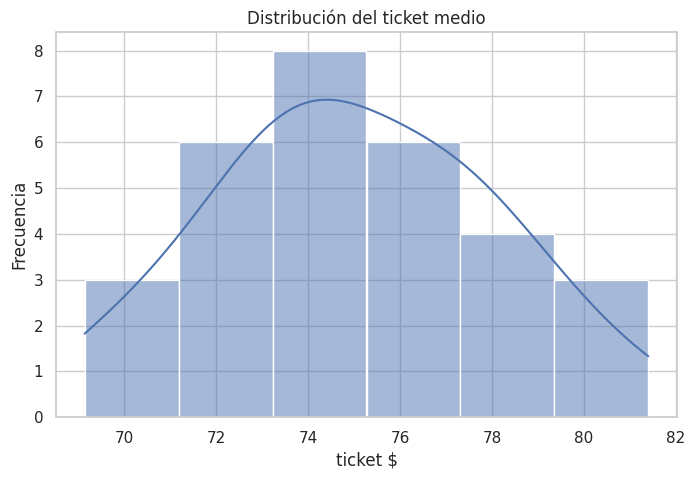

In [16]:
#Distribucion de ticket medio
plt.figure(figsize=(8,5))
sns.histplot(prod_global["ticket_medio"], kde=True)
plt.title("Distribución del ticket medio")
plt.xlabel("ticket $")
plt.ylabel("Frecuencia")
plt.show()

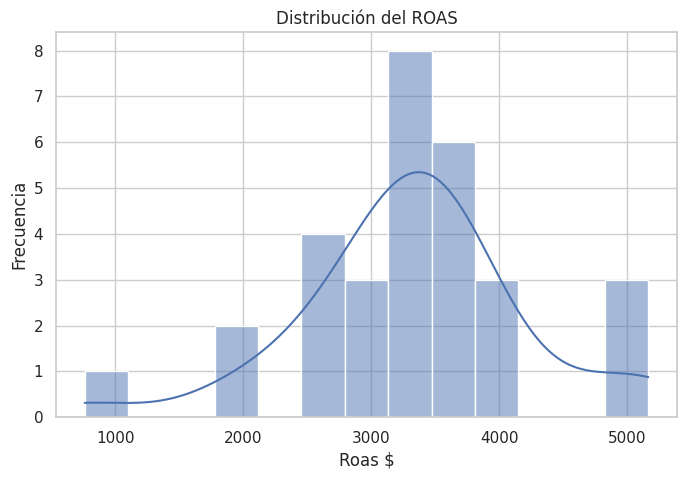

In [17]:
#Distribucion de ROAS
plt.figure(figsize=(8,5))
sns.histplot(prod_global["ROAS"], kde=True)
plt.title("Distribución del ROAS")
plt.xlabel("Roas $")
plt.ylabel("Frecuencia")
plt.show()

,anio_mes,ventas_totales,unidades_totales,cantidad_operaciones
0,2024-01,129604.99,1741.0,268
1,2024-02,118672.44,1607.0,248
2,2024-03,136779.15,1792.0,265
3,2024-04,128430.69,1715.0,275
4,2024-05,143727.25,1812.0,275
5,2024-06,108480.17,1426.0,221
6,2024-07,116229.97,1547.0,243
7,2024-08,119680.15,1614.0,254
8,2024-09,115787.85,1576.0,241
9,2024-10,112117.13,1458.0,230


,ventas_totales,unidades_totales,cantidad_operaciones
count,12.000000,12.000000,12.000000
mean,122257.793333,1624.583333,249.833333
std,10361.463891,121.610749,17.683240
min,108480.170000,1426.000000,221.000000
25%,116119.440000,1568.750000,240.000000
50%,119176.295000,1610.500000,245.500000
75%,128724.265000,1721.500000,265.750000
max,143727.250000,1812.000000,275.000000


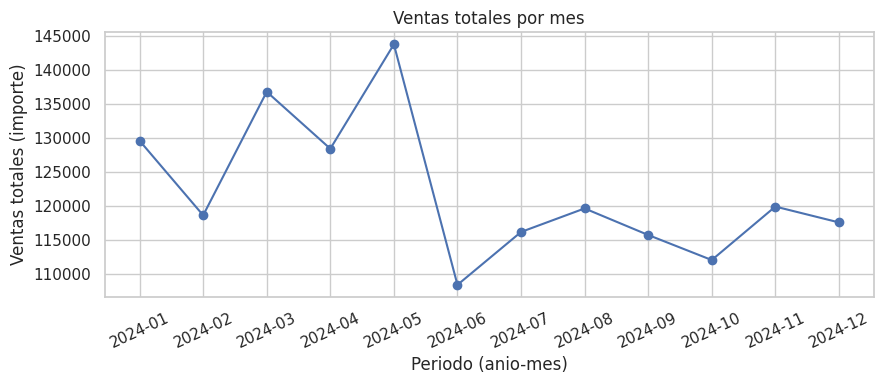

In [18]:
#Para ver la evolución de las ventas a lo largo del tiempo construimos una vista de "ventas" por mes:

# tiempo construimos una vista de "ventas" por mes:
ventas['anio_mes'] = ventas['fecha_venta'].dt.to_period('M').astype(str) # "2023-04"

# Agrupamos las ventas por mes
ventas_mes = (ventas
              .groupby('anio_mes', as_index=False)
              .agg(
                  ventas_totales=('importe', 'sum'),
                  unidades_totales=('cantidad', 'sum'),
                  cantidad_operaciones=('importe', 'count')
              ))

display(ventas_mes.head(12))
display(ventas_mes.describe())
#
# Grafico del total de ventas por mes
plt.figure(figsize=(9, 4))

plt.plot(
    ventas_mes['anio_mes'],
    ventas_mes['ventas_totales'],
    marker='o'
)

plt.title("Ventas totales por mes")
plt.xlabel("Periodo (anio-mes)")
plt.ylabel("Ventas totales (importe)")
plt.xticks(rotation=25)
plt.tight_layout()
plt.show()

,producto,ventas_total,unidades_vendidas,ticket_medio,ROAS
0,Lámpara de mesa,82276.38,1112.0,73.99,5164.87
1,Auriculares,74175.58,958.0,77.43,4867.16
2,Microondas,72562.89,912.0,79.56,5113.66
3,Cafetera,59607.31,765.0,77.92,3282.34
4,Cuadro decorativo,54297.60,726.0,74.79,3425.72
5,Smartphone,54132.44,665.0,81.40,3426.10
6,Secadora,52115.45,696.0,74.88,3572.00
7,Jarrón decorativo,51130.88,672.0,76.09,3853.12
8,Batidora,50979.20,672.0,75.86,3336.34
9,Rincón de plantas,50456.45,691.0,73.02,3067.26


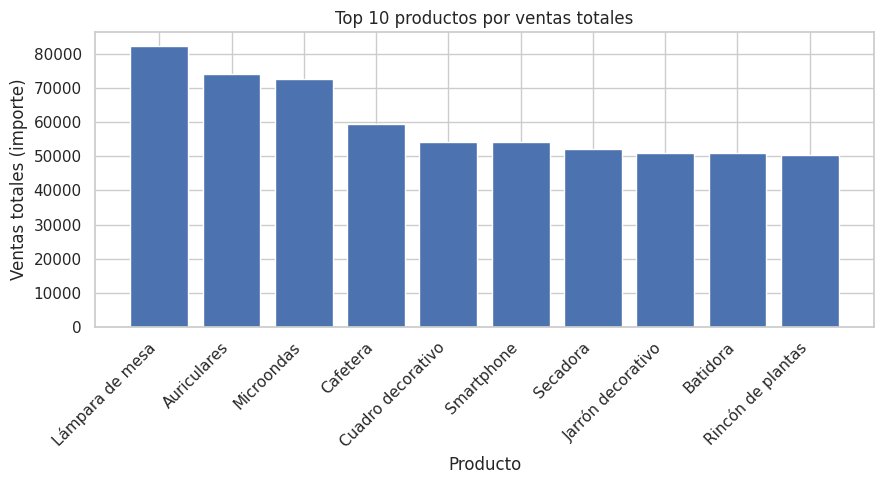

In [19]:
# 10 productos con mayor total de ventas
N = 10
top_productos = prod_global.nlargest(N, 'ventas_total')
display(top_productos[['producto', 'ventas_total', 'unidades_vendidas', 'ticket_medio', 'ROAS']])

#Grafico de los 10 producto con mayor total de ventas
plt.figure(figsize=(9, 5))
plt.bar(top_productos['producto'], top_productos['ventas_total'])
plt.title(f"Top {N} productos por ventas totales")
plt.xlabel("Producto")
plt.ylabel("Ventas totales (importe)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

**Comentario sobre el EDA**

Ventas Totales y Unidades Vendidas:

*   A lo largo de los meses se nota cierta estabilidad, con un pico importante en mayo 143.727$ (1812 unidades vendidas)
*   Junio es un mes atípico del añoo a 108.480 $.(1426 unidades vendidas)

Cantidad de Operaciones:

*   La cantidad de operaciones es bastante estable.
*   Los meses con más operaciones coinciden con los de mejores ventas.
*   Nuevamente junio muestra un descenso significativo.

Top 10 productos con mas ventas totales:

*   Lámpara de mesa es el producto estrella, con la mayor facturación.
*   Smartphone vende menos unidades, pero su ticket medio es el más alto.
*   Smartphone es el producto más caro, aunque no es el más vendido.
*   Ticket medio entre productos es bastante homogéneo (entre 73 y 81$).
*   Lámpara de mesa, Microondas y Auriculares tienen los mejores ratios de retorno.
*   Rincón de plantas posee el ROAS más bajo del grupo.


### 3.3 Correlacion
Evaluar la relación entre diferentes variables (por ejemplo,
precio y cantidad vendida) y mostrar los resultados en un gráfico.

,importe,cantidad,precio
importe,1.000000,0.773009,0.558846
cantidad,0.773009,1.000000,-0.002388
precio,0.558846,-0.002388,1.000000


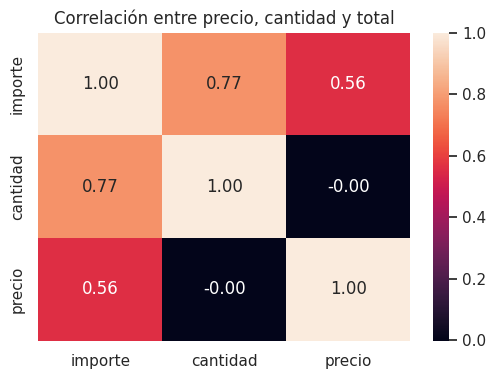

In [20]:
# Matriz de correlación de prod_global
corr = ventas[['importe','cantidad','precio']].corr()
display(corr)
print("\n")

plt.figure(figsize=(6,4))
sns.heatmap(corr, annot=True, fmt='.2f')
plt.title('Correlación entre precio, cantidad y total')
plt.show()

,ventas_total,unidades_vendidas,inversion_total,ticket_medio,ROAS
ventas_total,1.000000,0.990684,0.242179,0.464691,0.916866
unidades_vendidas,0.990684,1.000000,0.259788,0.347205,0.900989
inversion_total,0.242179,0.259788,1.000000,-0.029902,-0.156537
ticket_medio,0.464691,0.347205,-0.029902,1.000000,0.481477
ROAS,0.916866,0.900989,-0.156537,0.481477,1.000000


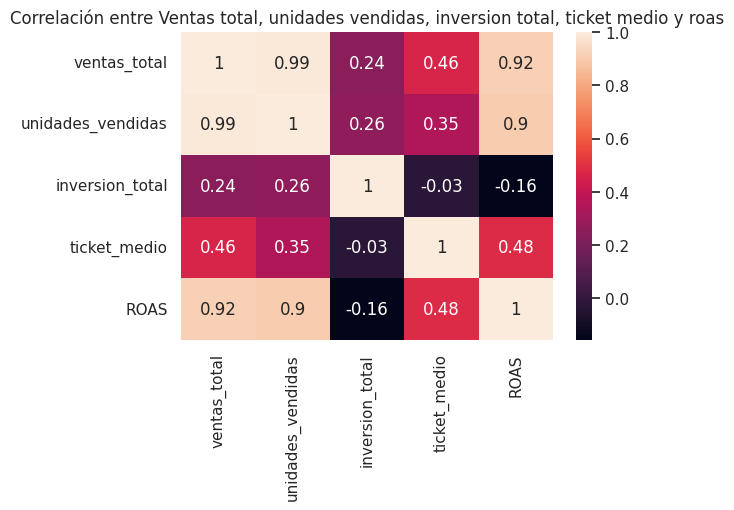

In [21]:
# Matriz de correlación de prod_global
corr = prod_global[['ventas_total','unidades_vendidas','inversion_total','ticket_medio','ROAS']].corr()
display(corr)
print("\n")

plt.figure(figsize=(6,4))
sns.heatmap(corr, annot=True)
plt.title('Correlación entre Ventas total, unidades vendidas, inversion total, ticket medio y roas')
plt.show()


Algunas sugerencias:



*   A medida que aumentan las unidades vendidas, aumentan casi proporcionalmente las ventas totales.
*   Los productos con mejor retorno publicitario (ROAS) tienden a generar mayores ventas.
*   Cuando el ticket medio sube, las ventas totales también tienden a crecer, pero no tanto como con las unidades.
*   Hay una relación muy baja entre la inversión en publicidad y la facturación.
*   sto significa que invertir más no garantiza vender más.
*   Puede haber estrategias ineficientes o productos que venden bien sin mucha inversión.
*   Cuanto más se invierte, ligeramente baja el ROAS.

### 3.4 Consolidacion de datos
Consolidar todos los análisis previos y preparar un conjunto de datos final que resuma los hallazgos clave para la presentación.

In [22]:
# Copia mod prod_global en df_final
df_final = prod_global[['producto',
                        'ventas_total',
                        'unidades_vendidas',
                        'inversion_total',
                        'campañas',
                        'ticket_medio',
                        'ROAS']].copy()


#Repartimos en 5 grupos (muy bajo, bajo, medio, alto, muy alto) para cualificar las ventas
df_final['segmento_ventas'] = pd.qcut(
            df_final['ventas_total'],
            q=5,
            labels=[
                'Muy Bajo',
                'Bajo',
                'Medio',
                'Alto',
                'Muy Alto'
                ]
             )


# Mostramos el 10 ejemplares aleatorios del dataframe
display(df_final.sample(10))

# Guardamos el resumen en un CSV
df_final.to_csv("resumen_productos.csv", index=False)


,producto,ventas_total,unidades_vendidas,inversion_total,campañas,ticket_medio,ROAS,segmento_ventas
0,Lámpara de mesa,82276.38,1112.0,15.93,3,73.99,5164.87,Muy Alto
7,Jarrón decorativo,51130.88,672.0,13.27,3,76.09,3853.12,Alto
20,Laptop,46179.48,617.0,15.19,3,74.85,3040.12,Bajo
26,Alfombra,44773.06,615.0,17.46,3,72.80,2564.32,Muy Bajo
11,Aspiradora,50085.86,651.0,16.46,3,76.94,3042.88,Alto
22,Elementos de cerámica,45411.09,636.0,16.87,3,71.40,2691.83,Bajo
21,Consola de videojuegos,46174.41,623.0,12.77,3,74.12,3615.85,Bajo
16,SmartWatch,47836.86,620.0,14.50,3,77.16,3299.09,Medio
13,Lavadora,48946.44,671.0,11.85,3,72.95,4130.50,Medio
8,Batidora,50979.20,672.0,15.28,3,75.86,3336.34,Alto


## Etapa 4: Visualización de Datos

Objetivo: Aprender a visualizar datos de manera efectiva utilizando diversas
bibliotecas.
Actividades:
1. Visualización con Matplotlib: Crear gráficos básicos (líneas, barras,
dispersión) que representen las ventas con diferentes periodos de tiempo.
2. Visualización Avanzada con Seaborn: Desarrollar visualizaciones
estadísticas avanzadas, utilizando paletas y estilos para mejorar la
presentación.
3. Visualización Interactiva con Plotly: Construir un dashboard interactivo
que combine múltiples visualizaciones, permitiendo al usuario explorar los
datos dinámicamente.
4. Presentación Final: Preparar una presentación que resuma los hallazgos,
insights y visualizaciones generadas a lo largo del proyecto. Presentar ante
un panel simulado de "expertos" en SynthData, recibiendo feedback sobre el
trabajo realizado.

###4.1 Visualización con Matplotlib:
Crear gráficos básicos (líneas, barras, dispersión) que representen las ventas con diferentes periodos de tiempo.

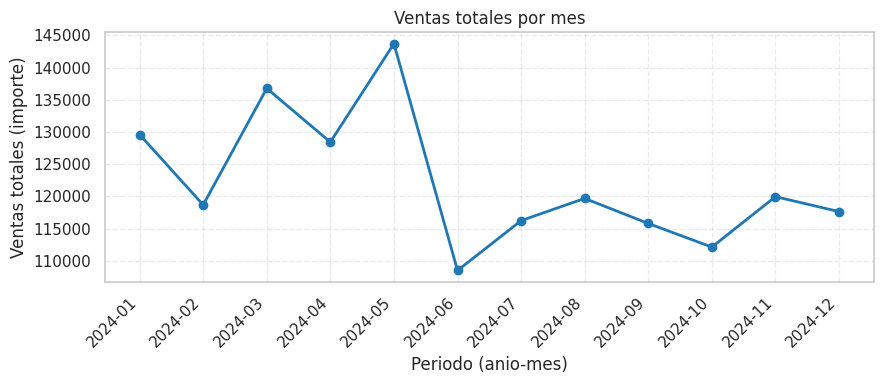

In [23]:
# Grafico de LINEA (ventas mensuales)

plt.figure(figsize=(9, 4))

plt.plot(
    ventas_mes['anio_mes'],
    ventas_mes['ventas_totales'],
    color='tab:blue',
    marker='o',
    linestyle='-',
    linewidth=2
)

plt.title("Ventas totales por mes")
plt.xlabel("Periodo (anio-mes)")
plt.ylabel("Ventas totales (importe)")
plt.xticks(rotation=45, ha='right')
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

In [102]:
ventas_mes.describe()

,ventas_totales,unidades_totales,cantidad_operaciones
count,12.000000,12.000000,12.000000
mean,122257.793333,1624.583333,249.833333
std,10361.463891,121.610749,17.683240
min,108480.170000,1426.000000,221.000000
25%,116119.440000,1568.750000,240.000000
50%,119176.295000,1610.500000,245.500000
75%,128724.265000,1721.500000,265.750000
max,143727.250000,1812.000000,275.000000


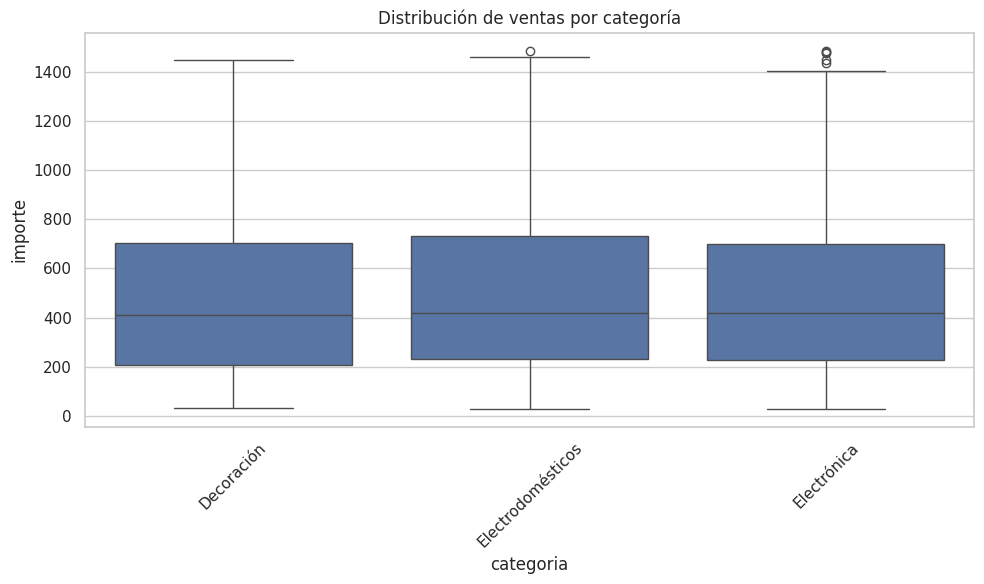

In [24]:
if 'categoria' in ventas.columns:
    plt.figure(figsize=(10,6))
    sns.boxplot(x='categoria', y='importe', data=ventas)
    plt.title('Distribución de ventas por categoría')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print('No existe columna categoria para boxplot')

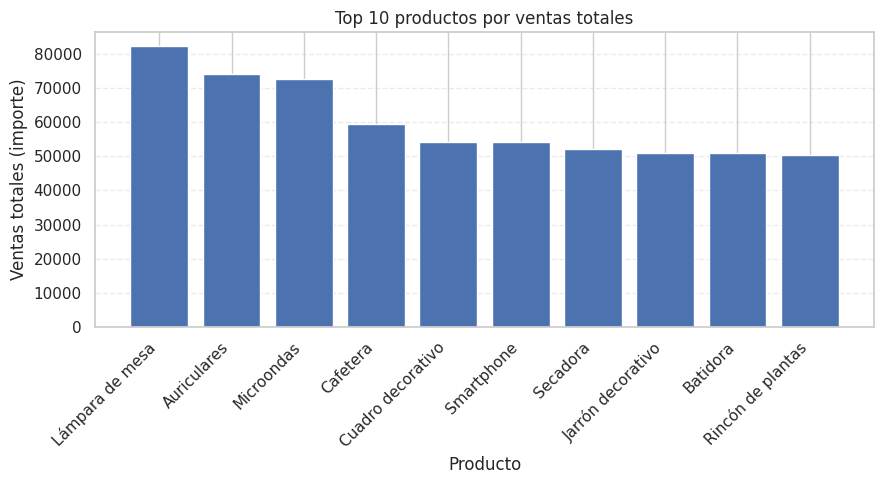

In [25]:
#Grafico de BARRAS (Top 10 productos)
plt.figure(figsize=(9, 5))

plt.bar(
    top_productos['producto'],
    top_productos['ventas_total'],
)

plt.title(f"Top 10 productos por ventas totales")
plt.xlabel("Producto")
plt.ylabel("Ventas totales (importe)")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

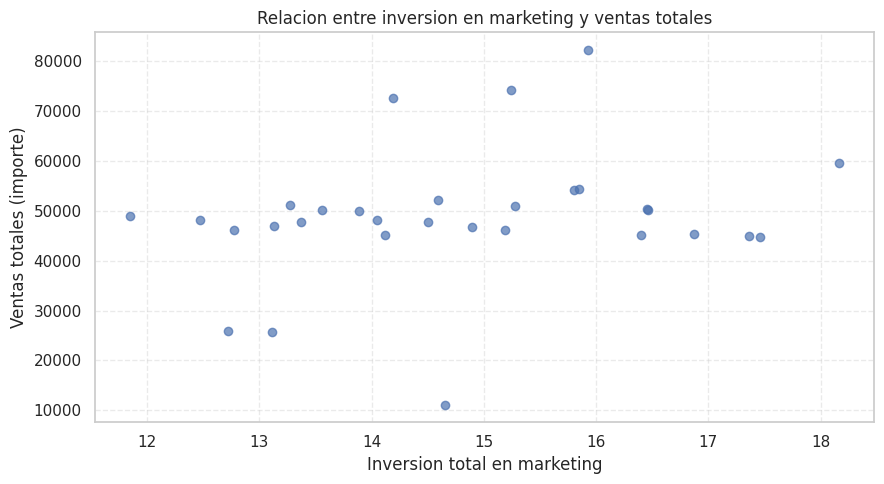

In [26]:
# Grafico de DISPERSION (inversion vs ventas)

plt.figure(figsize=(9, 5))

plt.scatter(
    df_final['inversion_total'],
    df_final['ventas_total'],
    alpha=0.7
)

plt.title("Relacion entre inversion en marketing y ventas totales")
plt.xlabel("Inversion total en marketing")
plt.ylabel("Ventas totales (importe)")
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


###4.2 Visualización Avanzada con Seaborn:
 Desarrollar visualizaciones estadísticas avanzadas, utilizando paletas y estilos para mejorar la presentación.

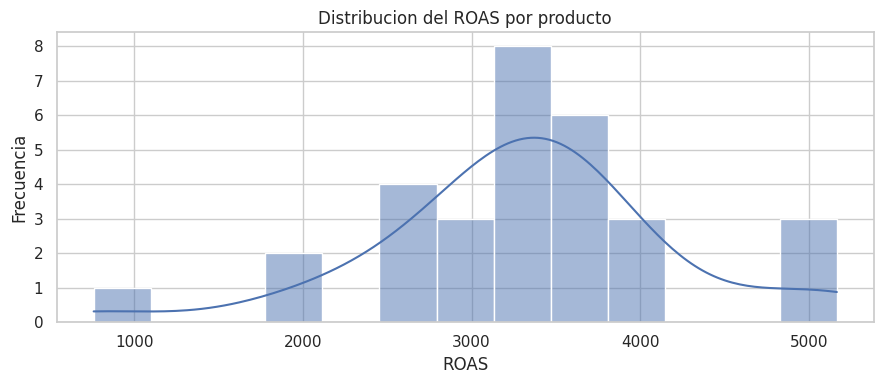

In [27]:
# Histograma + KDE de ROAS

plt.figure(figsize=(9, 4))

sns.histplot(
    data=df_final,
    x='ROAS',
    kde=True
)

plt.title("Distribucion del ROAS por producto")
plt.xlabel("ROAS")
plt.ylabel("Frecuencia")
plt.tight_layout()
plt.show()

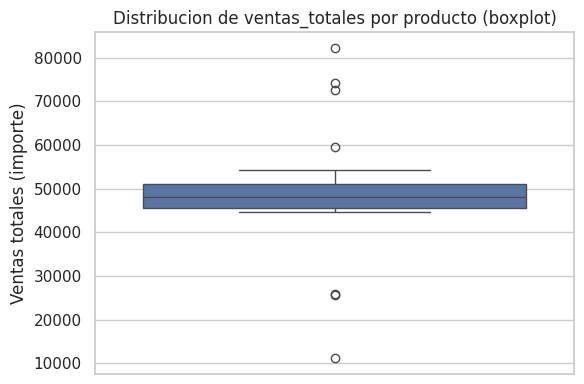

In [28]:
#Distribucion de ventas totales por producto
plt.figure(figsize=(6, 4))

sns.boxplot(
    data=df_final,
    y='ventas_total'
)

plt.title("Distribucion de ventas_totales por producto (boxplot)")
plt.ylabel("Ventas totales (importe)")
plt.tight_layout()
plt.show()


,ventas_total,unidades_vendidas,inversion_total,ticket_medio,ROAS
ventas_total,1.000000,0.990684,0.242179,0.464691,0.916866
unidades_vendidas,0.990684,1.000000,0.259788,0.347205,0.900989
inversion_total,0.242179,0.259788,1.000000,-0.029902,-0.156537
ticket_medio,0.464691,0.347205,-0.029902,1.000000,0.481477
ROAS,0.916866,0.900989,-0.156537,0.481477,1.000000


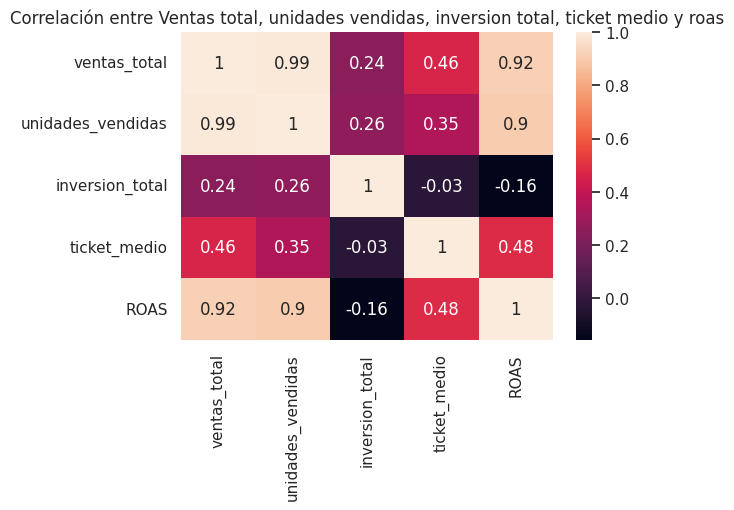

In [29]:
# Matriz de correlación de prod_global
corr = prod_global[['ventas_total','unidades_vendidas','inversion_total','ticket_medio','ROAS']].corr()
display(corr)
print("\n")

plt.figure(figsize=(6,4))
sns.heatmap(corr, annot=True)
plt.title('Correlación entre Ventas total, unidades vendidas, inversion total, ticket medio y roas')
plt.show()


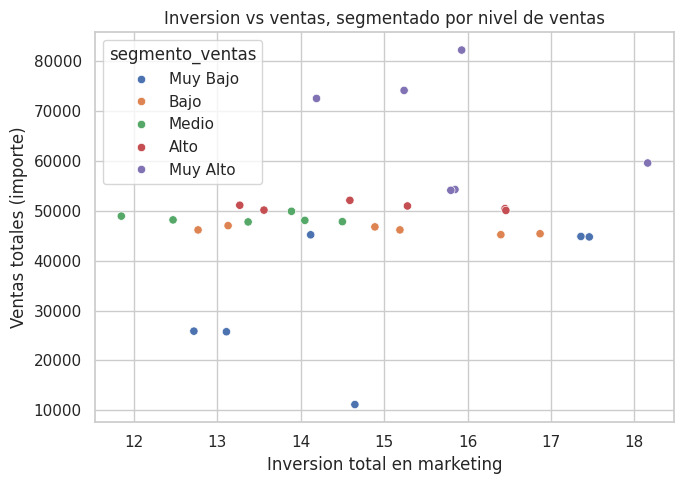

In [30]:
# Seaborn - Scatter con hue (segmento de ventas)

plt.figure(figsize=(7, 5))

sns.scatterplot(
    data=df_final,
    x='inversion_total',
    y='ventas_total',
    hue='segmento_ventas'
)

plt.title("Inversion vs ventas, segmentado por nivel de ventas")
plt.xlabel("Inversion total en marketing")
plt.ylabel("Ventas totales (importe)")
plt.tight_layout()
plt.show()

###4.3 Visualización Interactiva con Plotly:
Construir un dashboard interactivo que combine múltiples visualizaciones, permitiendo al usuario explorar los datos dinámicamente.

In [100]:
# ----------------------------------------------------
# Importamos modulos necesarios
# ----------------------------------------------------
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# ----------------------------------------------------
# Creamos la figura del tablero con subplots
# ----------------------------------------------------
fig_dashboard = make_subplots(
    rows=3, cols=2,
    specs=[
        [{"type": "xy"}, {"type": "xy"}],
        [{"type": "xy", "colspan": 2},None],
        [{"type": "xy"}, {"type": "xy"}]
    ],
    subplot_titles=(
        "Ventas totales por producto",
        "Ventas totales por mes",
        "Inversion en marketing vs ventas totales",
        "Roas por segmento",
        "Top 10 de productos con mas ventas"
    )
)

# ----------------------------------------------------
# Graficos interactivos a incluir en el dashboard
# ----------------------------------------------------

# 1) Barras interactivas (ventas por producto)
fig_bar = px.bar(
    df_final.sort_values('ventas_total', ascending=False),
    x='producto',
    y='ventas_total',
    hover_data=['unidades_vendidas', 'ticket_medio', 'ROAS'],
    color='segmento_ventas',
    title='Ventas totales por producto'
)
fig_bar.update_layout(xaxis_tickangle=-45)

# 2) Linea interactiva (ventas mensuales)
fig_line = px.line(
    ventas_mes,
    x='anio_mes',
    y='ventas_totales',
    title='Ventas totales por mes',
    markers=True
)
fig_line.update_layout(xaxis_tickangle=-45)

# 3) Scatter interactivo (inversion vs ventas)
fig_scatter = px.scatter(
    df_final,
    x='inversion_total',
    y='ventas_total',
    color='segmento_ventas',
    hover_data=['producto', 'ROAS', 'ticket_medio'],
    title='Inversion vs Ventas Totales'
)

# 4) barras
fig_bar2 = px.bar(
    top_productos,
    x='producto',
    y='ventas_total',

    hover_data=['producto', 'ROAS', 'ticket_medio'],
    title='Top 10 de productos con mas ventas'

)


#5)
fig_hist = px.histogram(
    df_final,
    x='ROAS',
    nbins=20,
    color='segmento_ventas',

    title='Roas por segmento'

)



# ----------------------------------------------------
# Agregamos los gráficos en cada "hueco" del dashboard
# ----------------------------------------------------

# Barras (fila 1, col 1)
for trace in fig_bar.data:
    fig_dashboard.add_trace(trace, row=1, col=1)

# Linea (fila 1, col 2)
for trace in fig_line.data:
    fig_dashboard.add_trace(trace, row=1, col=2)

# Scatter (fila 2, col 1-2)
for trace in fig_scatter.data:
    fig_dashboard.add_trace(trace, row=2, col=1)

for trace in fig_hist.data:
    fig_dashboard.add_trace(trace, row=3, col=1)

for trace in fig_bar2.data:
    fig_dashboard.add_trace(trace, row=3, col=2)


# ----------------------------------------------------
# Ajustes de ejes y layout general
# ----------------------------------------------------
fig_dashboard.update_xaxes(tickangle=-45, row=1, col=1)
fig_dashboard.update_xaxes(tickangle=-45, row=1, col=2)

fig_dashboard.update_layout(
    height=700,
    width=900,
    title_text="Dashboard de ventas y marketing (Plotly interactivo)",
    showlegend=True,
    margin=dict(l=40, r=40, t=80, b=40)
)

# ----------------------------------------------------
# Mostramos el dashboard
# ----------------------------------------------------
fig_dashboard.show()


### 4.4 Presentacion final


###1. Nuestro objetivo fue responder tres preguntas clave:

* ¿Qué productos generan más ingresos y volumen?
* ¿Qué tan eficiente es la inversión publicitaria?
* ¿Qué variables explican mejor las ventas?

Para eso se analizo:

* Ventas totales por mes
* Rendimiento individual de productos
* Ticket medio
* Inversión publicitaria (ROAS e inversión total)
* Volumen de operaciones y unidades vendidas
* Correlación entre variables

Lo que encontramos revela una historia clara sobre cómo vende el negocio y qué lo impulsa.

###2. La historia comienza con las ventas mensuales

Los datos del 2024 muestran:

* Ventas mensuales promedio: $122.257
* Meses más fuertes: marzo y mayo
* Mes más débil: junio
* Las unidades vendidas acompañan fielmente esta tendencia
* Las operaciones y monto total están alineados

**Conclusión inicial:**
El negocio tiene una estacionalidad suave, con pequeños picos de demanda y un valle marcado en mitad de año.

###3. Los Productos “Estrella”

Los que explican la mayor parte del éxito:

* Lámpara de mesa
* Auriculares
* Microondas

Estos tres concentran:

* Las ventas más altas
* Las mayores unidades vendidas
* Los mejores ROAS del catálogo

Son productos fáciles de vender, con gran aceptación y publicidad muy eficiente.

###4. El ticket medio: un personaje secundario pero relevante

* Oscila entre 73 y 81$, con poca variabilidad.
* Smartphone tiene el ticket medio más alto, pero vende pocas unidades.

**Conclusión:**
El ticket medio afecta, pero no es el protagonista de las ventas.
Las ventas se explican más por cantidad que por precio promedio.

###5. La inversión publicitaria: un personaje polémico

Aquí surge un giro interesante:

* La correlación entre inversión y ventas es baja (0.24)
* La relación entre inversión y ROAS es ligeramente negativa (-0.15)

**Posible interpretación:**
Hay campañas que gastan de más sin generar retorno proporcional.


###6. El verdadero protagonista: las unidades vendidas

La correlación lo deja clarísimo:

* Ventas ↔ Unidades vendidas = 0.99 (casi perfecta)
* ROAS ↔ Unidades = 0.90 (muy alta)

Para este negocio, vender más unidades es lo que realmente mueve la facturación.


###7. ¿Qué impulsa el rendimiento publicitario?

El ROAS está muy relacionado con:

* Ventas totales → 0.91
* Unidades vendidas → 0.90
* Ticket medio → 0.48

**Interpretación:**
Las mejores campañas son las que promueven productos:

* con buen volumen,
* con ventas fuertes,
* y con precio medio razonable.

Los productos muy caros no necesariamente tienen el mejor ROAS.

###8. Recomendaciones estratégicas (basadas en los datos)
####A). Priorizar inversión en los productos “Estrella”

(Lámpara, Auriculares, Microondas)

Porque:

* Tienen mejor ROAS
* Generan más ingresos
* Tienen mayor volumen

Responden bien a la publicidad
La inversión aquí se convierte en ventas reales.

####B) Revisar y optimizar campañas con baja eficiencia

Especialmente:

* Rincón de plantas
* Batidora
* Cafetera

Posibles acciones:

* Reducir inversión temporalmente
* Probar nuevos canales

####C) No aumentar inversión indiscriminadamente

El análisis muestra que:

* Más inversión: no siempre más ventas
* Más inversión: suele bajar el ROAS


###9. Cierre de la historia

Los datos muestran un negocio con:

* Fuerte dependencia del volumen
* Productos estrella claramente identificables
* Campañas publicitarias con rendimiento desigual
* Ticket medio estable
* Inversión que no siempre genera resultados

La historia final es simple:

**Para crecer, no hay que invertir más, sino invertir mejor.
Y el camino más seguro es seguir potenciando lo que ya funciona.**

#**Anexo**
####**Archivos subidos al drive para la Entrega Final**
**Descripción de los Datos**
*   Set de datos.pdf

**Datos**
*   ventas.csv
*   clientes.csv
*   marketing.csv

**DataFrame Final**
* resumen_productos.csv

**Archivo Colab con la pre entrega**
*   Cañete Javier Dario - Comisión 25261 - TPI Data Analytics.ipynb

**Github**

[https://github.com/JotaDC/TPI-Data-Analytics-TalentoTech](https://github.com/JotaDC/TPI-Data-Analytics-TalentoTech)




